In [ ]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import torch
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch.utils
import torch.utils.data
import scipy.signal
import sklearn.svm
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Seed set for reproducibility.")


INPUT_LENGTH = 9000
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_CLASSES = 4
EPOCHS = 10
N_FFT = 256
HOP_LENGTH = 128



train_df = pd.read_pickle("train_df.pkl")
val_df = pd.read_pickle("val_df.pkl")
test_df = pd.read_pickle("test_data.pkl")
print(train_df.head())

Seed set for reproducibility.
                                              signal  label      rr_std
1  [-446, -541, -637, -733, -819, -858, -867, -87...      2  182.922570
3  [-1255, -1488, -1745, -2015, -2253, -2374, -23...      0  123.855300
4  [156, 189, 223, 255, 291, 330, 362, 380, 390, ...      0   32.132097
5  [-22, -27, -33, -38, -40, -39, -36, -30, -23, ...      1  145.925780
6  [291, 345, 405, 465, 510, 527, 516, 509, 507, ...      0   16.995531


***Use pad and pack sequence (dynamic sequence length) and assess LSTM GRU and baseline RNN (all with CNN)***

Use pad and trim (fixed sequence length) and assess LSTM GRU and baseline RNN (all with CNN) and CNN+SVM

Pick the strategy and architecture

Test data ----> base.csv

Use picked strategy and architecture and compare augmentations (warp, noise, shift, scale, all)

Pick a augmentation or combination of augmentations that works best

Test data ----> augment.csv

In [ ]:
def time_shift(signal, shift_range=(-100, 100)):
    shift = np.roll(signal, shift=random.randint(shift_range[0], shift_range[1]))
    return shift


def add_noise(signal, noise_level=0.1):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise


def time_warp(signal, warp_factor=0.1):
    return scipy.signal.resample(
        signal, int(len(signal) * (1 + np.random.uniform(-warp_factor, warp_factor)))
    )


def amplitude_scaling(signal, scale_range=(0.8, 1.2)):
    scale = random.uniform(scale_range[0], scale_range[1])
    return signal * scale


def augment(signal, augmentation="all"):
    if augmentation in ("all", "warp_only") and np.random.rand() < 0.5:
        signal = time_warp(signal)
    if augmentation in ("all", "noise_only") and np.random.rand() < 0.5:
        signal = add_noise(signal)
    if augmentation in ("all", "shift_only") and np.random.rand() < 0.5:
        signal = time_shift(signal)
    if augmentation in ("all", "scale_only") and np.random.rand() < 0.5:
        signal = amplitude_scaling(signal)
    return signal


class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None):
        self.df = df
        self.augmentation = augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)
        signal = augment(signal, self.augmentation)
        signal = torch.tensor(signal, dtype=torch.float32)

        label = int(self.df.iloc[idx]["label"])
        label = torch.tensor(label, dtype=torch.long)

        length = len(signal)

        return signal, label, length

def collate_fn(batch):
    # TODO: Optimization: sort by length
    signals, labels, lengths = zip(*batch)
    signals = [s.unsqueeze(-1) if s.dim() == 1 else s for s in signals]
    packed_signals = pack_sequence(signals, enforce_sorted=False)

    lengths = torch.tensor(lengths, dtype=torch.int64)
    labels = torch.stack(labels)

    return packed_signals, labels, lengths


def batch_apply_stft(
    signals: torch.Tensor,
    lengths: torch.Tensor,
    n_fft: int = N_FFT,
    hop_length: int = HOP_LENGTH,
    pad_mode: str = "constant"
) -> tuple[torch.Tensor, torch.Tensor]:

    batch_stft = torch.stft(
        signals.squeeze(-1),
        n_fft,
        hop_length,
        window=torch.hann_window(n_fft, device=signals.device),
        pad_mode=pad_mode,
        return_complex=True,
    )
    magnitude = torch.abs(batch_stft)

    new_lengths = torch.clamp((lengths - n_fft) // hop_length + 1, min=1)

    return magnitude, new_lengths

def he_init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
class VorgabeRNN(nn.Module):
    def __init__(
        self,
        hidden_size=50,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=512,
        hop_length=256,
        dropout_rate=0.2,
    ):
        super(VorgabeRNN, self).__init__()

        # STFT parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_freqs = n_fft // 2 + 1

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.conv_output_size = 64 * (self.n_freqs // 4)

        self.rnn = nn.RNN(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.stft = batch_apply_stft
        self.apply(he_init_weights)

        self.rnn_type = type(self.rnn).__name__

    def feature_extractor(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        lengths = lengths.detach().clone().cpu()

        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x, lengths = self.stft(x, lengths, n_fft=self.n_fft, hop_length=self.hop_length)

        x = torch.log2(x + 1e-8)
        x = x.unsqueeze(1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        batch_size, channels, freq_bins, time_frames = x.shape
        x = x.view(batch_size, time_frames, -1)

        lengths = lengths // 4
        lengths = torch.clamp(lengths, min=1)

        x = torch.nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        if self.rnn_type == "LSTM":
            LSTM_output, (h_n, c_n) = self.rnn(x)
            return h_n[-1]
        else:
            RNN_output, RNN_states = self.rnn(x)
            return RNN_states[-1]

    def forward(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x, lengths)
        x = self.fc(x)
        return x

    def predict(self, x: PackedSequence, lengths: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.forward(x, lengths)
            _, predicted = torch.max(x, 1)
        return predicted


class VorgabeLSTM(VorgabeRNN):
    def __init__(self, hidden_size=50, num_layers=2, num_classes=NUM_CLASSES, n_fft=512, hop_length=256, dropout_rate=0.2):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.LSTM(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "LSTM"

class VorgabeGRU(VorgabeRNN):
    def __init__(self, hidden_size=50, num_layers=2, num_classes=NUM_CLASSES, n_fft=512, hop_length=256, dropout_rate=0.2):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.GRU(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "GRU"

In [ ]:
def train_model(model, train_loader, epochs=10, lr=0.001):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    original_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2, 3]),
    y=train_df['label'].values
)

    # Normalize and scale the weights
    scaled_weights = original_weights / original_weights.max()  # normalize to max=1
    scaled_weights = 0.5 + (scaled_weights * 0.5)  # shrink range to [0.5, 1.0] for balance

    weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    print("Training RNN feature extractor...")
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for signals, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            signals, labels, lengths = signals.to(device), labels.to(device), lengths.to(device)

            optimizer.zero_grad()
            outputs = model(signals, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100.0 * correct / total
        print(
            f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%"
        )
    return model

def evaluate_model(model, val_loader, device):
    print("Evaluating model...")
    model.eval()
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for signals, labels, lengths in tqdm(val_loader, desc="Evaluating"):
            signals, lengths = (
                signals.to(device),
                lengths.to(device),
            )

            predictions = model.predict(signals, lengths)
            predictions = predictions.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_predictions))

    # confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    # normalize heatmap colors in each row for class distribution
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy

Picking Model Architecture (No Augmentation)

Starting tests with different configurations...
Testing VorgabeLSTM with dropout 0.1, learning rate 0.001, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:06<00:00, 12.34it/s]


Epoch 1: Train Loss: 1.0887, Train Acc: 58.15%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.33it/s]


Epoch 2: Train Loss: 1.0684, Train Acc: 58.19%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.24it/s]


Epoch 3: Train Loss: 1.0654, Train Acc: 58.53%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 18.25it/s]


Epoch 4: Train Loss: 1.0581, Train Acc: 58.07%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 18.26it/s]


Epoch 5: Train Loss: 1.0617, Train Acc: 58.28%


Epoch 6/10: 100%|██████████| 83/83 [00:05<00:00, 16.48it/s]


Epoch 6: Train Loss: 1.0585, Train Acc: 58.49%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 18.09it/s]


Epoch 7: Train Loss: 1.0565, Train Acc: 58.07%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 18.81it/s]


Epoch 8: Train Loss: 1.0601, Train Acc: 58.19%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 14.41it/s]


Epoch 9: Train Loss: 1.0592, Train Acc: 58.26%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 18.21it/s]


Epoch 10: Train Loss: 1.0678, Train Acc: 57.79%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 30.83it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5804
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.58       927
   macro avg       0.15      0.25      0.18       927
weighted avg       0.34      0.58      0.43       927



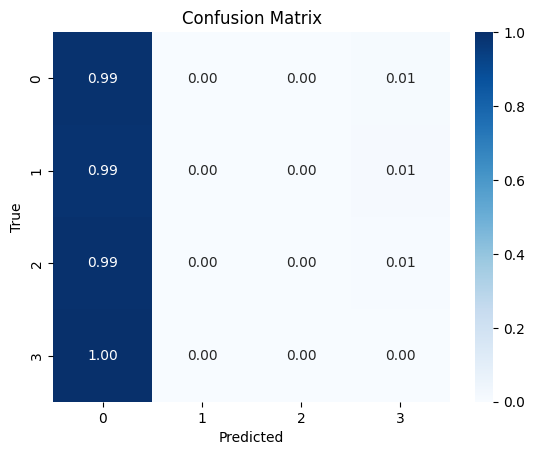

Validation Accuracy of VorgabeLSTM with dropout 0.1, learning rate 0.001, hidden size 128: 0.5804

Testing VorgabeLSTM with dropout 0.1, learning rate 0.0005, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:05<00:00, 16.19it/s]


Epoch 1: Train Loss: 1.0809, Train Acc: 58.30%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 17.82it/s]


Epoch 2: Train Loss: 1.0660, Train Acc: 58.04%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 18.02it/s]


Epoch 3: Train Loss: 1.0557, Train Acc: 57.94%


Epoch 4/10: 100%|██████████| 83/83 [00:05<00:00, 16.10it/s]


Epoch 4: Train Loss: 1.0450, Train Acc: 57.84%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.83it/s]


Epoch 5: Train Loss: 1.0372, Train Acc: 58.09%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.80it/s]


Epoch 6: Train Loss: 1.0208, Train Acc: 58.38%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.03it/s]


Epoch 7: Train Loss: 1.0203, Train Acc: 58.53%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 18.13it/s]


Epoch 8: Train Loss: 0.9981, Train Acc: 58.78%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 16.67it/s]


Epoch 9: Train Loss: 1.0027, Train Acc: 58.87%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.11it/s]


Epoch 10: Train Loss: 0.9897, Train Acc: 59.71%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.25it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5545
              precision    recall  f1-score   support

           0       0.60      0.91      0.73       544
           1       0.00      0.00      0.00        84
           2       0.29      0.05      0.09       264
           3       0.07      0.11      0.09        35

    accuracy                           0.55       927
   macro avg       0.24      0.27      0.23       927
weighted avg       0.44      0.55      0.46       927



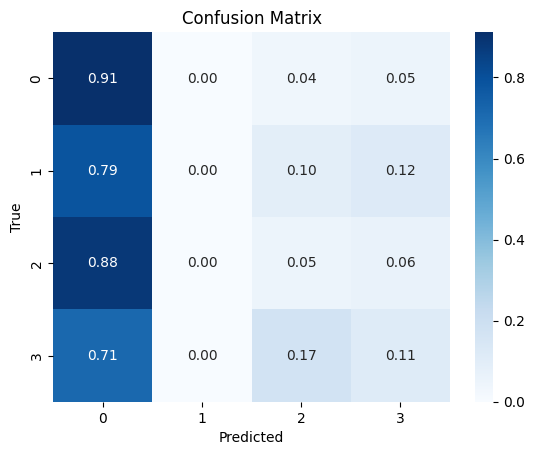

Validation Accuracy of VorgabeLSTM with dropout 0.1, learning rate 0.0005, hidden size 128: 0.5545

Testing VorgabeLSTM with dropout 0.1, learning rate 0.001, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.21it/s]


Epoch 1: Train Loss: 1.0845, Train Acc: 57.52%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 14.42it/s]


Epoch 2: Train Loss: 1.0730, Train Acc: 58.24%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.07it/s]


Epoch 3: Train Loss: 1.0671, Train Acc: 58.38%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 16.70it/s]


Epoch 4: Train Loss: 1.0724, Train Acc: 58.23%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.15it/s]


Epoch 5: Train Loss: 1.0630, Train Acc: 58.21%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.14it/s]


Epoch 6: Train Loss: 1.0681, Train Acc: 58.51%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 15.51it/s]


Epoch 7: Train Loss: 1.0427, Train Acc: 57.94%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.07it/s]


Epoch 8: Train Loss: 1.0227, Train Acc: 57.90%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.18it/s]


Epoch 9: Train Loss: 1.0045, Train Acc: 58.63%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 15.64it/s]


Epoch 10: Train Loss: 0.9918, Train Acc: 58.99%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 30.74it/s]


Final Validation Accuracy: 0.5976
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       544
           1       0.20      0.02      0.04        84
           2       0.49      0.08      0.14       264
           3       0.00      0.00      0.00        35

    accuracy                           0.60       927
   macro avg       0.32      0.27      0.23       927
weighted avg       0.52      0.60      0.48       927



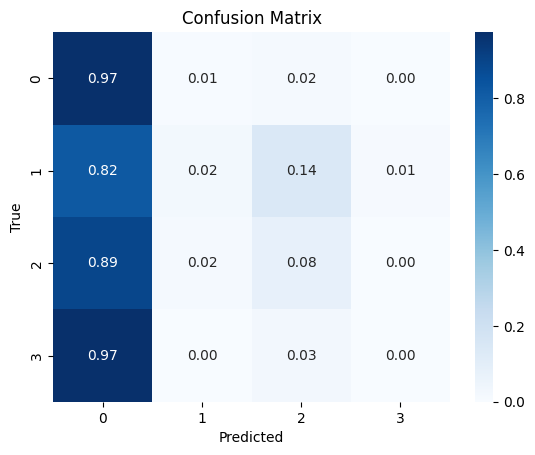

Validation Accuracy of VorgabeLSTM with dropout 0.1, learning rate 0.001, hidden size 256: 0.5976

Testing VorgabeLSTM with dropout 0.1, learning rate 0.0005, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 16.89it/s]


Epoch 1: Train Loss: 1.0787, Train Acc: 57.58%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 15.53it/s]


Epoch 2: Train Loss: 1.0635, Train Acc: 58.26%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.04it/s]


Epoch 3: Train Loss: 1.0604, Train Acc: 58.13%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.13it/s]


Epoch 4: Train Loss: 1.0691, Train Acc: 57.79%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 15.58it/s]


Epoch 5: Train Loss: 1.0484, Train Acc: 58.47%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.12it/s]


Epoch 6: Train Loss: 1.0267, Train Acc: 58.47%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.46it/s]


Epoch 7: Train Loss: 1.0160, Train Acc: 58.49%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.03it/s]


Epoch 8: Train Loss: 0.9851, Train Acc: 58.87%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.77it/s]


Epoch 9: Train Loss: 0.9771, Train Acc: 60.05%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 16.16it/s]


Epoch 10: Train Loss: 0.9326, Train Acc: 60.72%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 30.65it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5858
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       544
           1       0.00      0.00      0.00        84
           2       0.47      0.03      0.05       264
           3       0.00      0.00      0.00        35

    accuracy                           0.59       927
   macro avg       0.27      0.25      0.20       927
weighted avg       0.48      0.59      0.45       927



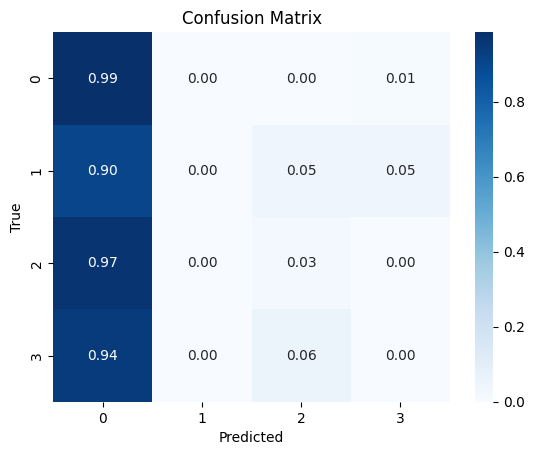

Validation Accuracy of VorgabeLSTM with dropout 0.1, learning rate 0.0005, hidden size 256: 0.5858

Testing VorgabeLSTM with dropout 0.2, learning rate 0.001, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 18.41it/s]


Epoch 1: Train Loss: 1.0781, Train Acc: 58.00%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.64it/s]


Epoch 2: Train Loss: 1.0852, Train Acc: 58.40%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.59it/s]


Epoch 3: Train Loss: 1.0638, Train Acc: 58.26%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 18.50it/s]


Epoch 4: Train Loss: 1.0506, Train Acc: 57.75%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 18.14it/s]


Epoch 5: Train Loss: 1.0213, Train Acc: 57.90%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 16.99it/s]


Epoch 6: Train Loss: 1.0049, Train Acc: 58.40%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 18.40it/s]


Epoch 7: Train Loss: 0.9891, Train Acc: 59.81%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.55it/s]


Epoch 8: Train Loss: 0.9714, Train Acc: 59.94%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.15it/s]


Epoch 9: Train Loss: 0.9609, Train Acc: 59.96%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 18.10it/s]


Epoch 10: Train Loss: 0.9565, Train Acc: 60.83%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.49it/s]


Final Validation Accuracy: 0.5566
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       544
           1       0.16      0.06      0.09        84
           2       0.40      0.34      0.37       264
           3       0.00      0.00      0.00        35

    accuracy                           0.56       927
   macro avg       0.30      0.29      0.29       927
weighted avg       0.51      0.56      0.53       927



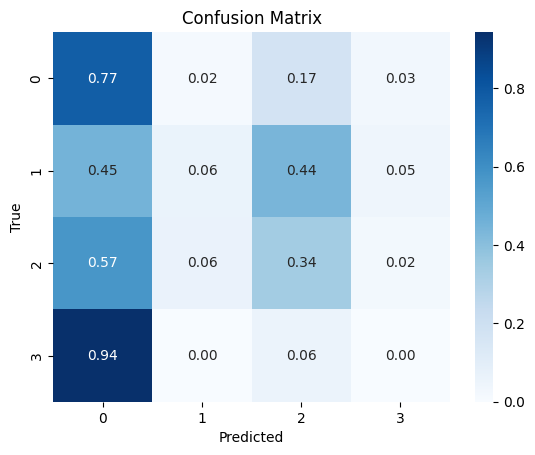

Validation Accuracy of VorgabeLSTM with dropout 0.2, learning rate 0.001, hidden size 128: 0.5566

Testing VorgabeLSTM with dropout 0.2, learning rate 0.0005, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:05<00:00, 15.73it/s]


Epoch 1: Train Loss: 1.0866, Train Acc: 58.68%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.38it/s]


Epoch 2: Train Loss: 1.0635, Train Acc: 58.40%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.91it/s]


Epoch 3: Train Loss: 1.0601, Train Acc: 58.51%


Epoch 4/10: 100%|██████████| 83/83 [00:05<00:00, 16.50it/s]


Epoch 4: Train Loss: 1.0658, Train Acc: 57.94%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 18.40it/s]


Epoch 5: Train Loss: 1.0549, Train Acc: 58.42%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.06it/s]


Epoch 6: Train Loss: 1.0512, Train Acc: 58.45%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.13it/s]


Epoch 7: Train Loss: 1.0539, Train Acc: 58.04%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.87it/s]


Epoch 8: Train Loss: 1.0381, Train Acc: 58.09%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 16.09it/s]


Epoch 9: Train Loss: 1.0346, Train Acc: 58.34%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 18.01it/s]


Epoch 10: Train Loss: 1.0303, Train Acc: 58.38%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.67it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5717
              precision    recall  f1-score   support

           0       0.58      0.97      0.73       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.57       927
   macro avg       0.15      0.24      0.18       927
weighted avg       0.34      0.57      0.43       927



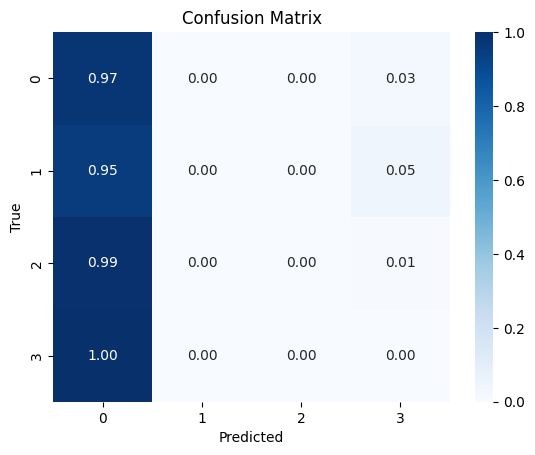

Validation Accuracy of VorgabeLSTM with dropout 0.2, learning rate 0.0005, hidden size 128: 0.5717

Testing VorgabeLSTM with dropout 0.2, learning rate 0.001, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 16.97it/s]


Epoch 1: Train Loss: 1.0999, Train Acc: 57.56%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 15.91it/s]


Epoch 2: Train Loss: 1.0697, Train Acc: 58.00%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.48it/s]


Epoch 3: Train Loss: 1.0665, Train Acc: 57.88%


Epoch 4/10: 100%|██████████| 83/83 [00:05<00:00, 16.57it/s]


Epoch 4: Train Loss: 1.0592, Train Acc: 58.57%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.04it/s]


Epoch 5: Train Loss: 1.0594, Train Acc: 57.83%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.37it/s]


Epoch 6: Train Loss: 1.0677, Train Acc: 58.26%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.09it/s]


Epoch 7: Train Loss: 1.0580, Train Acc: 57.94%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.54it/s]


Epoch 8: Train Loss: 1.0679, Train Acc: 58.63%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.48it/s]


Epoch 9: Train Loss: 1.0539, Train Acc: 58.00%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 16.03it/s]


Epoch 10: Train Loss: 1.0550, Train Acc: 58.64%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.68it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5868
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.59       927
   macro avg       0.15      0.25      0.18       927
weighted avg       0.34      0.59      0.43       927



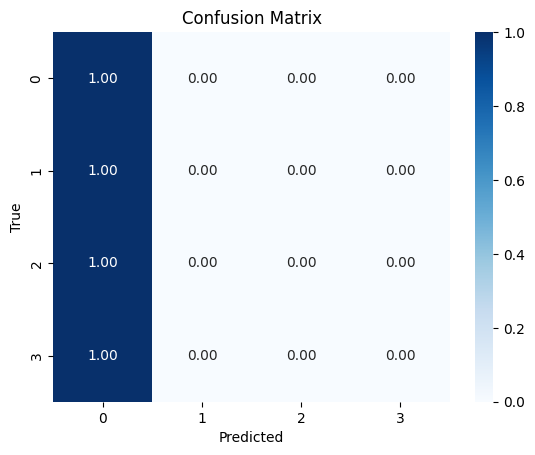

Validation Accuracy of VorgabeLSTM with dropout 0.2, learning rate 0.001, hidden size 256: 0.5868

Testing VorgabeLSTM with dropout 0.2, learning rate 0.0005, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.68it/s]


Epoch 1: Train Loss: 1.0923, Train Acc: 57.60%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 16.02it/s]


Epoch 2: Train Loss: 1.0765, Train Acc: 58.53%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.46it/s]


Epoch 3: Train Loss: 1.0516, Train Acc: 58.17%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.59it/s]


Epoch 4: Train Loss: 1.0137, Train Acc: 59.06%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 15.91it/s]


Epoch 5: Train Loss: 0.9989, Train Acc: 59.08%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.36it/s]


Epoch 6: Train Loss: 0.9934, Train Acc: 59.29%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 16.61it/s]


Epoch 7: Train Loss: 0.9854, Train Acc: 59.56%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 16.65it/s]


Epoch 8: Train Loss: 0.9580, Train Acc: 59.58%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 16.69it/s]


Epoch 9: Train Loss: 0.9457, Train Acc: 61.12%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 15.76it/s]


Epoch 10: Train Loss: 0.9478, Train Acc: 61.25%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.16it/s]


Final Validation Accuracy: 0.5782
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       544
           1       0.50      0.04      0.07        84
           2       0.45      0.22      0.30       264
           3       0.14      0.31      0.19        35

    accuracy                           0.58       927
   macro avg       0.44      0.36      0.32       927
weighted avg       0.56      0.58      0.53       927



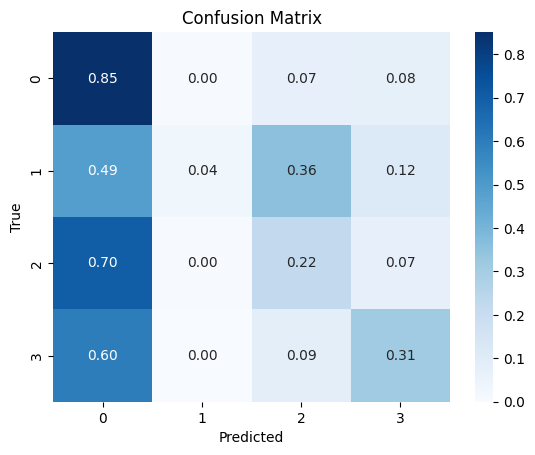

Validation Accuracy of VorgabeLSTM with dropout 0.2, learning rate 0.0005, hidden size 256: 0.5782

Testing VorgabeGRU with dropout 0.1, learning rate 0.001, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.86it/s]


Epoch 1: Train Loss: 1.1209, Train Acc: 56.59%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 17.21it/s]


Epoch 2: Train Loss: 1.0636, Train Acc: 57.77%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.33it/s]


Epoch 3: Train Loss: 1.0188, Train Acc: 58.05%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.88it/s]


Epoch 4: Train Loss: 0.9951, Train Acc: 59.42%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.17it/s]


Epoch 5: Train Loss: 0.9590, Train Acc: 60.15%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.15it/s]


Epoch 6: Train Loss: 0.9341, Train Acc: 61.20%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 18.00it/s]


Epoch 7: Train Loss: 0.9020, Train Acc: 63.39%


Epoch 8/10: 100%|██████████| 83/83 [00:05<00:00, 15.61it/s]


Epoch 8: Train Loss: 0.8687, Train Acc: 64.39%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.91it/s]


Epoch 9: Train Loss: 0.7830, Train Acc: 68.74%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.70it/s]


Epoch 10: Train Loss: 0.7306, Train Acc: 71.73%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 24.19it/s]


Final Validation Accuracy: 0.6483
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       544
           1       0.31      0.18      0.23        84
           2       0.50      0.64      0.56       264
           3       0.22      0.06      0.09        35

    accuracy                           0.65       927
   macro avg       0.45      0.41      0.41       927
weighted avg       0.64      0.65      0.64       927



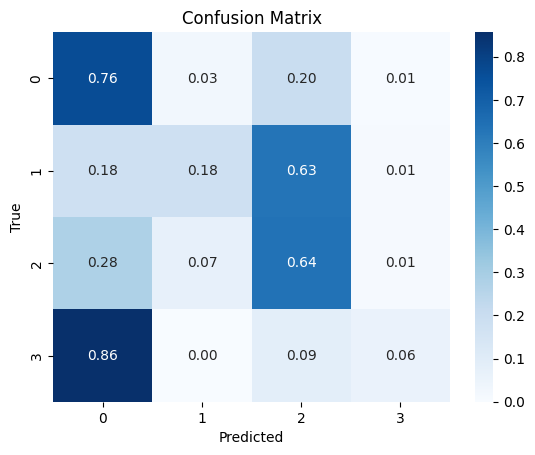

Validation Accuracy of VorgabeGRU with dropout 0.1, learning rate 0.001, hidden size 128: 0.6483

Testing VorgabeGRU with dropout 0.1, learning rate 0.0005, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 16.80it/s]


Epoch 1: Train Loss: 1.0965, Train Acc: 57.31%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.21it/s]


Epoch 2: Train Loss: 1.0700, Train Acc: 58.30%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 16.74it/s]


Epoch 3: Train Loss: 1.0624, Train Acc: 58.17%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.22it/s]


Epoch 4: Train Loss: 1.0537, Train Acc: 58.64%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.91it/s]


Epoch 5: Train Loss: 1.0354, Train Acc: 59.08%


Epoch 6/10: 100%|██████████| 83/83 [00:05<00:00, 16.11it/s]


Epoch 6: Train Loss: 0.9994, Train Acc: 58.45%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.89it/s]


Epoch 7: Train Loss: 0.9815, Train Acc: 60.03%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 18.25it/s]


Epoch 8: Train Loss: 0.9669, Train Acc: 59.31%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 16.16it/s]


Epoch 9: Train Loss: 0.9446, Train Acc: 60.83%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 18.10it/s]


Epoch 10: Train Loss: 0.9089, Train Acc: 62.81%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.36it/s]


Final Validation Accuracy: 0.5965
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       544
           1       0.25      0.01      0.02        84
           2       0.45      0.48      0.46       264
           3       0.00      0.00      0.00        35

    accuracy                           0.60       927
   macro avg       0.35      0.32      0.30       927
weighted avg       0.56      0.60      0.56       927



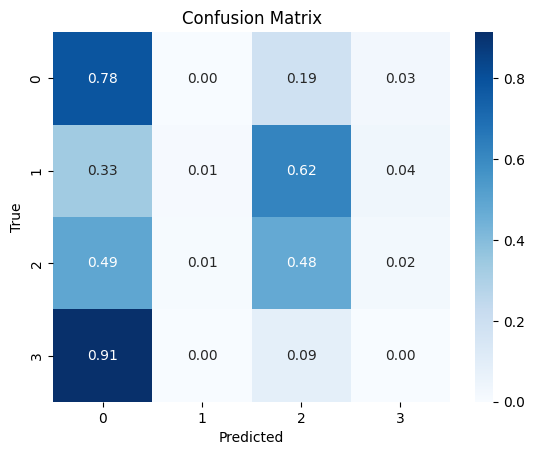

Validation Accuracy of VorgabeGRU with dropout 0.1, learning rate 0.0005, hidden size 128: 0.5965

Testing VorgabeGRU with dropout 0.1, learning rate 0.001, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:05<00:00, 16.13it/s]


Epoch 1: Train Loss: 1.1576, Train Acc: 57.39%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 16.90it/s]


Epoch 2: Train Loss: 1.0712, Train Acc: 57.25%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.83it/s]


Epoch 3: Train Loss: 1.0527, Train Acc: 57.12%


Epoch 4/10: 100%|██████████| 83/83 [00:05<00:00, 15.79it/s]


Epoch 4: Train Loss: 1.0493, Train Acc: 57.96%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.97it/s]


Epoch 5: Train Loss: 1.0158, Train Acc: 56.97%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.78it/s]


Epoch 6: Train Loss: 0.9861, Train Acc: 59.63%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 15.78it/s]


Epoch 7: Train Loss: 0.9880, Train Acc: 59.60%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.70it/s]


Epoch 8: Train Loss: 0.9235, Train Acc: 61.63%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 16.84it/s]


Epoch 9: Train Loss: 0.9040, Train Acc: 62.93%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 16.69it/s]


Epoch 10: Train Loss: 0.8688, Train Acc: 64.24%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.55it/s]


Final Validation Accuracy: 0.6462
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       544
           1       0.00      0.00      0.00        84
           2       0.51      0.41      0.46       264
           3       0.48      0.86      0.61        35

    accuracy                           0.65       927
   macro avg       0.42      0.53      0.46       927
weighted avg       0.58      0.65      0.61       927



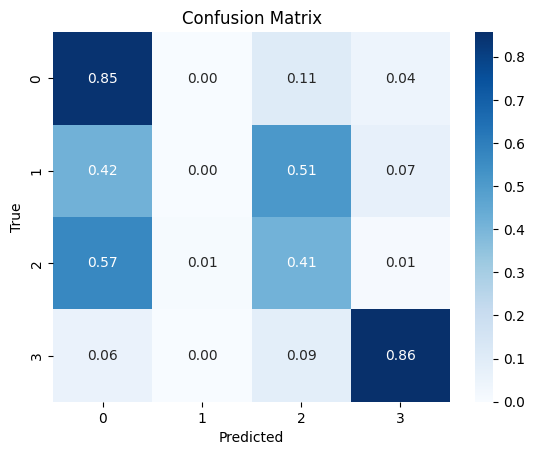

Validation Accuracy of VorgabeGRU with dropout 0.1, learning rate 0.001, hidden size 256: 0.6462

Testing VorgabeGRU with dropout 0.1, learning rate 0.0005, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.82it/s]


Epoch 1: Train Loss: 1.1148, Train Acc: 57.10%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 15.93it/s]


Epoch 2: Train Loss: 1.0727, Train Acc: 56.93%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.49it/s]


Epoch 3: Train Loss: 1.0533, Train Acc: 57.75%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.37it/s]


Epoch 4: Train Loss: 1.0104, Train Acc: 58.23%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.09it/s]


Epoch 5: Train Loss: 0.9803, Train Acc: 59.20%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.49it/s]


Epoch 6: Train Loss: 0.9507, Train Acc: 60.36%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.41it/s]


Epoch 7: Train Loss: 0.9087, Train Acc: 62.95%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.06it/s]


Epoch 8: Train Loss: 0.9022, Train Acc: 63.18%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.31it/s]


Epoch 9: Train Loss: 0.8720, Train Acc: 64.62%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 15.54it/s]


Epoch 10: Train Loss: 0.8589, Train Acc: 64.68%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 26.79it/s]


Final Validation Accuracy: 0.5912
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       544
           1       0.33      0.01      0.02        84
           2       0.42      0.44      0.43       264
           3       0.04      0.03      0.03        35

    accuracy                           0.59       927
   macro avg       0.37      0.32      0.31       927
weighted avg       0.56      0.59      0.56       927



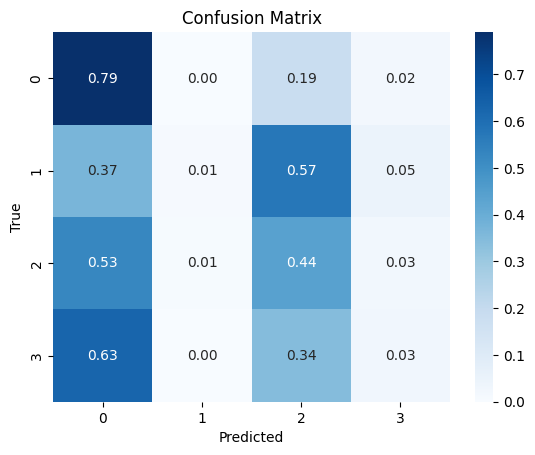

Validation Accuracy of VorgabeGRU with dropout 0.1, learning rate 0.0005, hidden size 256: 0.5912

Testing VorgabeGRU with dropout 0.2, learning rate 0.001, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.15it/s]


Epoch 1: Train Loss: 1.1015, Train Acc: 56.42%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 16.58it/s]


Epoch 2: Train Loss: 1.0720, Train Acc: 58.02%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.52it/s]


Epoch 3: Train Loss: 1.0671, Train Acc: 57.69%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.85it/s]


Epoch 4: Train Loss: 1.0464, Train Acc: 57.86%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.27it/s]


Epoch 5: Train Loss: 0.9981, Train Acc: 57.88%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.59it/s]


Epoch 6: Train Loss: 0.9860, Train Acc: 60.09%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.84it/s]


Epoch 7: Train Loss: 0.9433, Train Acc: 61.44%


Epoch 8/10: 100%|██████████| 83/83 [00:05<00:00, 16.13it/s]


Epoch 8: Train Loss: 0.9212, Train Acc: 62.74%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.80it/s]


Epoch 9: Train Loss: 0.8773, Train Acc: 64.41%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.92it/s]


Epoch 10: Train Loss: 0.8537, Train Acc: 65.92%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 23.26it/s]


Final Validation Accuracy: 0.6268
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       544
           1       0.33      0.31      0.32        84
           2       0.60      0.31      0.41       264
           3       0.07      0.06      0.06        35

    accuracy                           0.63       927
   macro avg       0.42      0.39      0.39       927
weighted avg       0.61      0.63      0.60       927



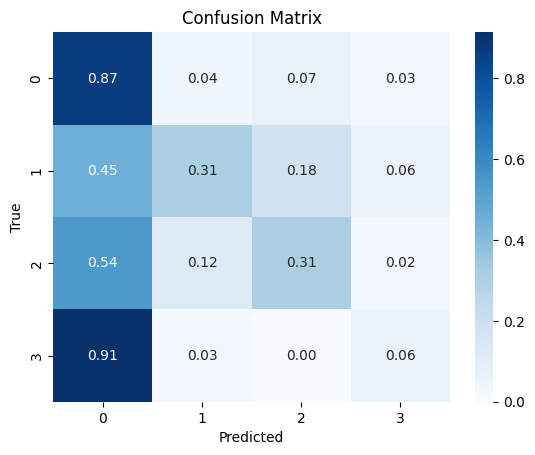

Validation Accuracy of VorgabeGRU with dropout 0.2, learning rate 0.001, hidden size 128: 0.6268

Testing VorgabeGRU with dropout 0.2, learning rate 0.0005, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 16.87it/s]


Epoch 1: Train Loss: 1.0984, Train Acc: 55.79%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.14it/s]


Epoch 2: Train Loss: 1.0689, Train Acc: 57.08%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.18it/s]


Epoch 3: Train Loss: 1.0712, Train Acc: 57.29%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.72it/s]


Epoch 4: Train Loss: 1.0371, Train Acc: 58.34%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 18.14it/s]


Epoch 5: Train Loss: 1.0130, Train Acc: 58.70%


Epoch 6/10: 100%|██████████| 83/83 [00:05<00:00, 16.18it/s]


Epoch 6: Train Loss: 0.9925, Train Acc: 58.76%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.88it/s]


Epoch 7: Train Loss: 0.9726, Train Acc: 59.82%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 18.02it/s]


Epoch 8: Train Loss: 0.9509, Train Acc: 59.98%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 16.00it/s]


Epoch 9: Train Loss: 0.9321, Train Acc: 60.81%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.93it/s]


Epoch 10: Train Loss: 0.9207, Train Acc: 61.01%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5965
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       544
           1       0.00      0.00      0.00        84
           2       0.57      0.13      0.22       264
           3       0.07      0.06      0.06        35

    accuracy                           0.60       927
   macro avg       0.32      0.28      0.26       927
weighted avg       0.53      0.60      0.50       927



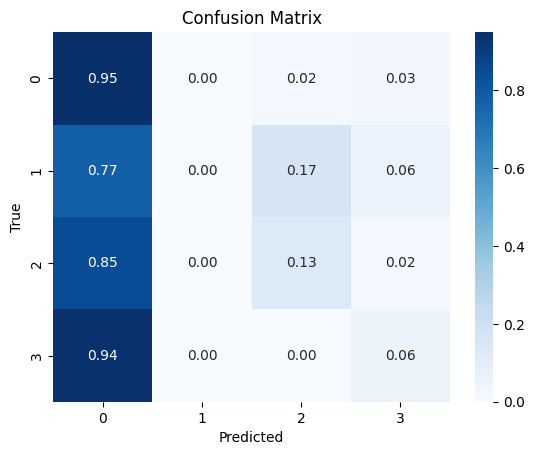

Validation Accuracy of VorgabeGRU with dropout 0.2, learning rate 0.0005, hidden size 128: 0.5965

Testing VorgabeGRU with dropout 0.2, learning rate 0.001, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:05<00:00, 16.26it/s]


Epoch 1: Train Loss: 1.1532, Train Acc: 54.91%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 17.25it/s]


Epoch 2: Train Loss: 1.0937, Train Acc: 57.71%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.46it/s]


Epoch 3: Train Loss: 1.0843, Train Acc: 57.60%


Epoch 4/10: 100%|██████████| 83/83 [00:05<00:00, 16.15it/s]


Epoch 4: Train Loss: 1.0809, Train Acc: 57.58%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.84it/s]


Epoch 5: Train Loss: 1.0792, Train Acc: 58.07%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.60it/s]


Epoch 6: Train Loss: 1.0612, Train Acc: 58.32%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.06it/s]


Epoch 7: Train Loss: 1.0637, Train Acc: 58.28%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.69it/s]


Epoch 8: Train Loss: 1.0622, Train Acc: 57.73%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 16.48it/s]


Epoch 9: Train Loss: 1.0547, Train Acc: 58.61%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 16.85it/s]


Epoch 10: Train Loss: 0.9974, Train Acc: 59.23%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


Final Validation Accuracy: 0.5750
              precision    recall  f1-score   support

           0       0.64      0.86      0.74       544
           1       0.24      0.10      0.14        84
           2       0.43      0.21      0.28       264
           3       0.03      0.03      0.03        35

    accuracy                           0.57       927
   macro avg       0.33      0.30      0.30       927
weighted avg       0.52      0.57      0.52       927



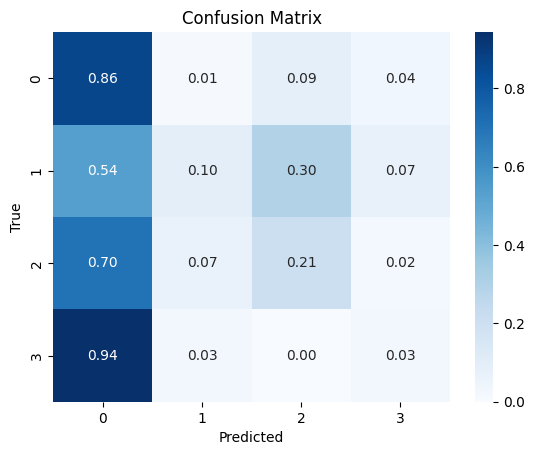

Validation Accuracy of VorgabeGRU with dropout 0.2, learning rate 0.001, hidden size 256: 0.5750

Testing VorgabeGRU with dropout 0.2, learning rate 0.0005, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.79it/s]


Epoch 1: Train Loss: 1.1367, Train Acc: 56.40%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 15.81it/s]


Epoch 2: Train Loss: 1.0824, Train Acc: 56.80%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.56it/s]


Epoch 3: Train Loss: 1.0830, Train Acc: 57.81%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.32it/s]


Epoch 4: Train Loss: 1.0665, Train Acc: 57.43%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.34it/s]


Epoch 5: Train Loss: 1.0376, Train Acc: 57.90%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.66it/s]


Epoch 6: Train Loss: 1.0200, Train Acc: 58.55%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.48it/s]


Epoch 7: Train Loss: 0.9842, Train Acc: 58.99%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.05it/s]


Epoch 8: Train Loss: 0.9663, Train Acc: 59.77%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.45it/s]


Epoch 9: Train Loss: 0.9411, Train Acc: 60.53%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 15.74it/s]


Epoch 10: Train Loss: 0.9247, Train Acc: 62.00%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 31.81it/s]


Final Validation Accuracy: 0.5534
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       544
           1       0.17      0.01      0.02        84
           2       0.46      0.27      0.34       264
           3       0.03      0.09      0.04        35

    accuracy                           0.55       927
   macro avg       0.33      0.29      0.28       927
weighted avg       0.54      0.55      0.53       927



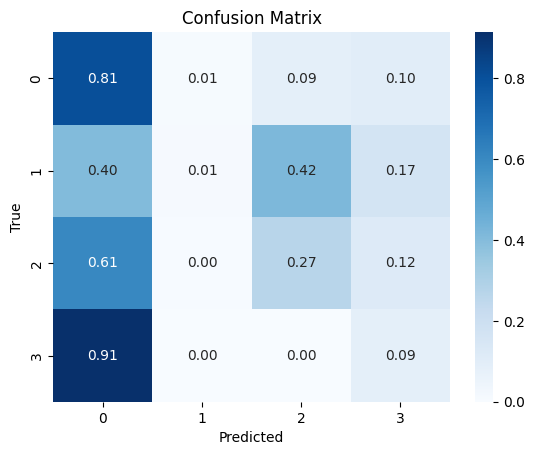

Validation Accuracy of VorgabeGRU with dropout 0.2, learning rate 0.0005, hidden size 256: 0.5534

Testing VorgabeRNN with dropout 0.1, learning rate 0.001, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.99it/s]


Epoch 1: Train Loss: 1.1080, Train Acc: 56.38%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 17.33it/s]


Epoch 2: Train Loss: 1.0940, Train Acc: 57.75%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.00it/s]


Epoch 3: Train Loss: 1.0889, Train Acc: 58.15%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 18.05it/s]


Epoch 4: Train Loss: 1.0711, Train Acc: 58.05%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 16.89it/s]


Epoch 5: Train Loss: 1.0664, Train Acc: 58.05%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.49it/s]


Epoch 6: Train Loss: 1.0616, Train Acc: 58.13%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 18.07it/s]


Epoch 7: Train Loss: 1.0697, Train Acc: 58.24%


Epoch 8/10: 100%|██████████| 83/83 [00:05<00:00, 16.22it/s]


Epoch 8: Train Loss: 1.0722, Train Acc: 57.67%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.93it/s]


Epoch 9: Train Loss: 1.0632, Train Acc: 58.07%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 18.23it/s]


Epoch 10: Train Loss: 1.0537, Train Acc: 58.34%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.11it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5426
              precision    recall  f1-score   support

           0       0.62      0.81      0.70       544
           1       0.00      0.00      0.00        84
           2       0.37      0.23      0.28       264
           3       0.02      0.03      0.03        35

    accuracy                           0.54       927
   macro avg       0.25      0.27      0.25       927
weighted avg       0.47      0.54      0.49       927



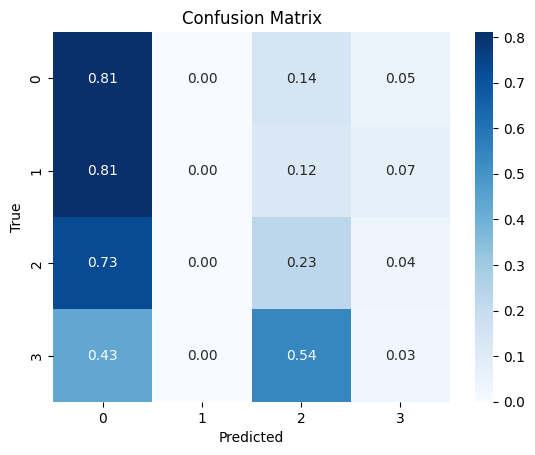

Validation Accuracy of VorgabeRNN with dropout 0.1, learning rate 0.001, hidden size 128: 0.5426

Testing VorgabeRNN with dropout 0.1, learning rate 0.0005, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 16.60it/s]


Epoch 1: Train Loss: 1.1236, Train Acc: 55.94%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.12it/s]


Epoch 2: Train Loss: 1.0763, Train Acc: 58.07%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.46it/s]


Epoch 3: Train Loss: 1.0502, Train Acc: 58.24%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 16.82it/s]


Epoch 4: Train Loss: 1.0233, Train Acc: 58.05%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 18.14it/s]


Epoch 5: Train Loss: 1.0105, Train Acc: 58.55%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 16.68it/s]


Epoch 6: Train Loss: 0.9969, Train Acc: 58.66%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.71it/s]


Epoch 7: Train Loss: 0.9684, Train Acc: 61.12%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 18.09it/s]


Epoch 8: Train Loss: 0.9676, Train Acc: 60.03%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 16.13it/s]


Epoch 9: Train Loss: 0.9470, Train Acc: 62.09%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.98it/s]


Epoch 10: Train Loss: 0.9554, Train Acc: 60.93%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.97it/s]


Final Validation Accuracy: 0.5922
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       544
           1       0.50      0.02      0.05        84
           2       0.48      0.41      0.44       264
           3       0.08      0.11      0.09        35

    accuracy                           0.59       927
   macro avg       0.43      0.34      0.33       927
weighted avg       0.58      0.59      0.56       927



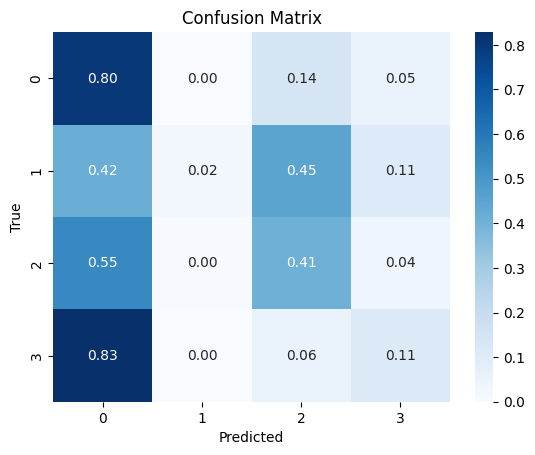

Validation Accuracy of VorgabeRNN with dropout 0.1, learning rate 0.0005, hidden size 128: 0.5922

Testing VorgabeRNN with dropout 0.1, learning rate 0.001, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.48it/s]


Epoch 1: Train Loss: 1.1553, Train Acc: 55.75%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 16.34it/s]


Epoch 2: Train Loss: 1.0937, Train Acc: 57.75%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.90it/s]


Epoch 3: Train Loss: 1.0754, Train Acc: 58.00%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 16.77it/s]


Epoch 4: Train Loss: 1.0859, Train Acc: 58.34%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.27it/s]


Epoch 5: Train Loss: 1.0703, Train Acc: 58.28%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.93it/s]


Epoch 6: Train Loss: 1.0595, Train Acc: 58.09%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 15.96it/s]


Epoch 7: Train Loss: 1.0598, Train Acc: 58.05%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.74it/s]


Epoch 8: Train Loss: 1.0774, Train Acc: 57.90%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.62it/s]


Epoch 9: Train Loss: 1.0476, Train Acc: 58.32%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 16.00it/s]


Epoch 10: Train Loss: 1.0408, Train Acc: 57.67%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.61it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5739
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.57       927
   macro avg       0.15      0.24      0.18       927
weighted avg       0.34      0.57      0.43       927



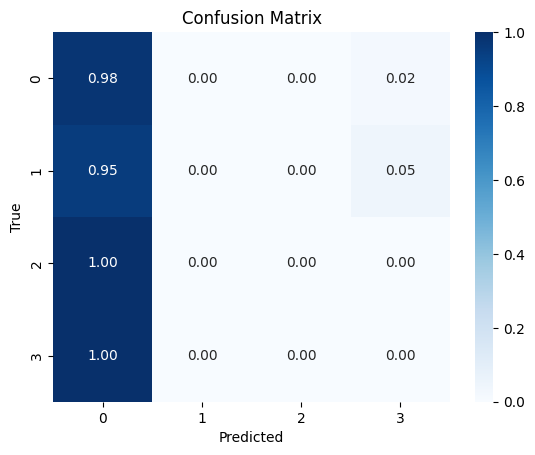

Validation Accuracy of VorgabeRNN with dropout 0.1, learning rate 0.001, hidden size 256: 0.5739

Testing VorgabeRNN with dropout 0.1, learning rate 0.0005, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.87it/s]


Epoch 1: Train Loss: 1.1548, Train Acc: 56.76%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 16.77it/s]


Epoch 2: Train Loss: 1.1150, Train Acc: 55.75%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.17it/s]


Epoch 3: Train Loss: 1.0916, Train Acc: 57.58%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.81it/s]


Epoch 4: Train Loss: 1.0691, Train Acc: 57.46%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.06it/s]


Epoch 5: Train Loss: 1.0641, Train Acc: 58.05%


Epoch 6/10: 100%|██████████| 83/83 [00:05<00:00, 15.48it/s]


Epoch 6: Train Loss: 1.0765, Train Acc: 57.77%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.56it/s]


Epoch 7: Train Loss: 1.0782, Train Acc: 57.44%


Epoch 8/10: 100%|██████████| 83/83 [00:05<00:00, 15.89it/s]


Epoch 8: Train Loss: 1.0702, Train Acc: 58.07%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.62it/s]


Epoch 9: Train Loss: 1.0624, Train Acc: 57.54%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 16.58it/s]


Epoch 10: Train Loss: 1.0596, Train Acc: 58.02%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 23.33it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5868
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.59       927
   macro avg       0.15      0.25      0.18       927
weighted avg       0.34      0.59      0.43       927



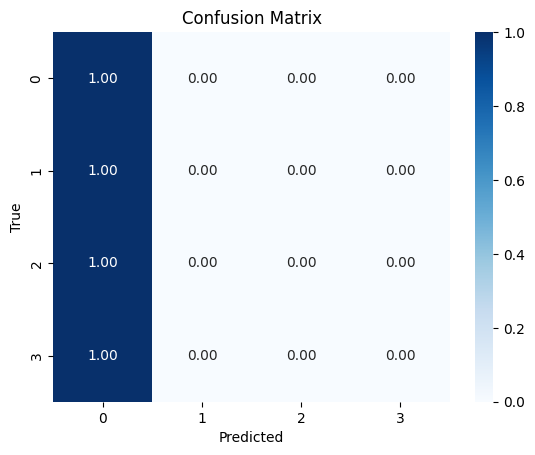

Validation Accuracy of VorgabeRNN with dropout 0.1, learning rate 0.0005, hidden size 256: 0.5868

Testing VorgabeRNN with dropout 0.2, learning rate 0.001, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.62it/s]


Epoch 1: Train Loss: 1.1269, Train Acc: 56.28%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 18.01it/s]


Epoch 2: Train Loss: 1.0875, Train Acc: 57.56%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.18it/s]


Epoch 3: Train Loss: 1.0798, Train Acc: 58.19%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 18.07it/s]


Epoch 4: Train Loss: 1.0759, Train Acc: 56.95%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.84it/s]


Epoch 5: Train Loss: 1.0678, Train Acc: 57.98%


Epoch 6/10: 100%|██████████| 83/83 [00:05<00:00, 16.15it/s]


Epoch 6: Train Loss: 1.0676, Train Acc: 57.96%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.90it/s]


Epoch 7: Train Loss: 1.0759, Train Acc: 58.51%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.06it/s]


Epoch 8: Train Loss: 1.0648, Train Acc: 58.09%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 16.94it/s]


Epoch 9: Train Loss: 1.0686, Train Acc: 58.11%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.80it/s]


Epoch 10: Train Loss: 1.0701, Train Acc: 57.03%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.22it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Validation Accuracy: 0.5340
              precision    recall  f1-score   support

           0       0.60      0.81      0.69       544
           1       0.00      0.00      0.00        84
           2       0.41      0.20      0.27       264
           3       0.05      0.09      0.06        35

    accuracy                           0.53       927
   macro avg       0.26      0.27      0.25       927
weighted avg       0.47      0.53      0.48       927



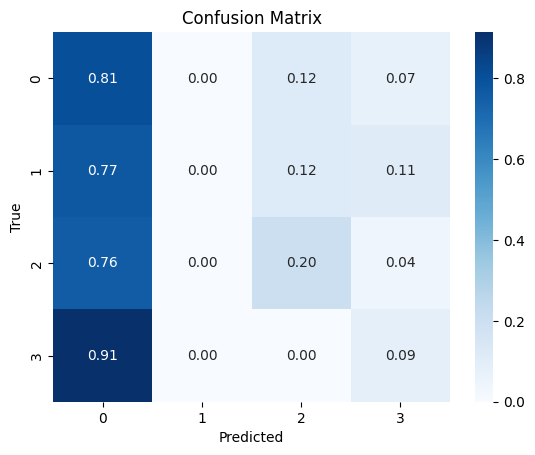

Validation Accuracy of VorgabeRNN with dropout 0.2, learning rate 0.001, hidden size 128: 0.5340

Testing VorgabeRNN with dropout 0.2, learning rate 0.0005, hidden size 128
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:05<00:00, 16.12it/s]


Epoch 1: Train Loss: 1.0980, Train Acc: 56.19%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 17.97it/s]


Epoch 2: Train Loss: 1.0575, Train Acc: 56.70%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 18.03it/s]


Epoch 3: Train Loss: 1.0118, Train Acc: 58.32%


Epoch 4/10: 100%|██████████| 83/83 [00:05<00:00, 16.20it/s]


Epoch 4: Train Loss: 1.0281, Train Acc: 58.15%


Epoch 5/10: 100%|██████████| 83/83 [00:04<00:00, 17.85it/s]


Epoch 5: Train Loss: 1.0014, Train Acc: 58.40%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.42it/s]


Epoch 6: Train Loss: 0.9779, Train Acc: 59.29%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.42it/s]


Epoch 7: Train Loss: 0.9855, Train Acc: 59.69%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.99it/s]


Epoch 8: Train Loss: 1.0027, Train Acc: 58.47%


Epoch 9/10: 100%|██████████| 83/83 [00:05<00:00, 16.49it/s]


Epoch 9: Train Loss: 0.9677, Train Acc: 60.66%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.11it/s]


Epoch 10: Train Loss: 1.0017, Train Acc: 58.40%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.56it/s]


Final Validation Accuracy: 0.5944
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       544
           1       1.00      0.01      0.02        84
           2       0.45      0.25      0.32       264
           3       0.05      0.03      0.04        35

    accuracy                           0.59       927
   macro avg       0.53      0.29      0.28       927
weighted avg       0.59      0.59      0.53       927



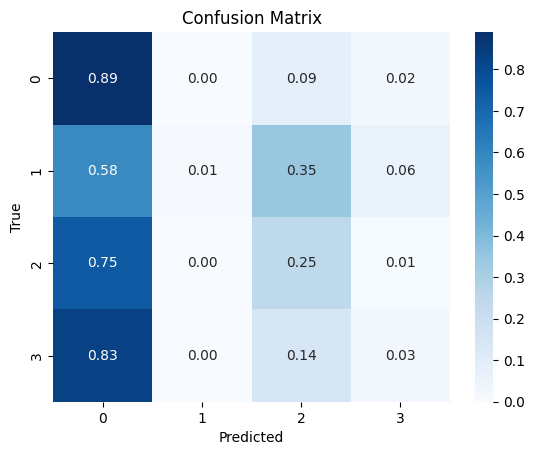

Validation Accuracy of VorgabeRNN with dropout 0.2, learning rate 0.0005, hidden size 128: 0.5944

Testing VorgabeRNN with dropout 0.2, learning rate 0.001, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.75it/s]


Epoch 1: Train Loss: 1.1731, Train Acc: 55.18%


Epoch 2/10: 100%|██████████| 83/83 [00:05<00:00, 15.80it/s]


Epoch 2: Train Loss: 1.0934, Train Acc: 57.46%


Epoch 3/10: 100%|██████████| 83/83 [00:04<00:00, 17.58it/s]


Epoch 3: Train Loss: 1.0859, Train Acc: 57.37%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.72it/s]


Epoch 4: Train Loss: 1.0898, Train Acc: 57.60%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.15it/s]


Epoch 5: Train Loss: 1.0850, Train Acc: 57.54%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 18.14it/s]


Epoch 6: Train Loss: 1.0695, Train Acc: 58.28%


Epoch 7/10: 100%|██████████| 83/83 [00:05<00:00, 16.34it/s]


Epoch 7: Train Loss: 1.0634, Train Acc: 58.17%


Epoch 8/10: 100%|██████████| 83/83 [00:04<00:00, 17.02it/s]


Epoch 8: Train Loss: 1.0662, Train Acc: 57.92%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.59it/s]


Epoch 9: Train Loss: 1.0681, Train Acc: 58.51%


Epoch 10/10: 100%|██████████| 83/83 [00:05<00:00, 15.88it/s]


Epoch 10: Train Loss: 1.0710, Train Acc: 58.42%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.40it/s]


Final Validation Accuracy: 0.5728
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       544
           1       0.22      0.05      0.08        84
           2       0.19      0.03      0.05       264
           3       0.00      0.00      0.00        35

    accuracy                           0.57       927
   macro avg       0.25      0.26      0.22       927
weighted avg       0.43      0.57      0.45       927



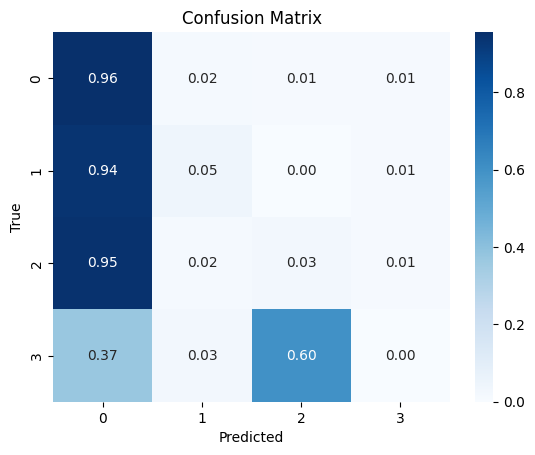

Validation Accuracy of VorgabeRNN with dropout 0.2, learning rate 0.001, hidden size 256: 0.5728

Testing VorgabeRNN with dropout 0.2, learning rate 0.0005, hidden size 256
Training RNN feature extractor...


Epoch 1/10: 100%|██████████| 83/83 [00:04<00:00, 17.70it/s]


Epoch 1: Train Loss: 1.1759, Train Acc: 54.00%


Epoch 2/10: 100%|██████████| 83/83 [00:04<00:00, 16.99it/s]


Epoch 2: Train Loss: 1.0892, Train Acc: 57.50%


Epoch 3/10: 100%|██████████| 83/83 [00:05<00:00, 16.19it/s]


Epoch 3: Train Loss: 1.0799, Train Acc: 57.79%


Epoch 4/10: 100%|██████████| 83/83 [00:04<00:00, 17.57it/s]


Epoch 4: Train Loss: 1.0988, Train Acc: 56.42%


Epoch 5/10: 100%|██████████| 83/83 [00:05<00:00, 16.01it/s]


Epoch 5: Train Loss: 1.0621, Train Acc: 58.19%


Epoch 6/10: 100%|██████████| 83/83 [00:04<00:00, 17.51it/s]


Epoch 6: Train Loss: 1.0719, Train Acc: 57.79%


Epoch 7/10: 100%|██████████| 83/83 [00:04<00:00, 17.92it/s]


Epoch 7: Train Loss: 1.0590, Train Acc: 58.32%


Epoch 8/10: 100%|██████████| 83/83 [00:05<00:00, 15.95it/s]


Epoch 8: Train Loss: 1.0577, Train Acc: 58.28%


Epoch 9/10: 100%|██████████| 83/83 [00:04<00:00, 17.80it/s]


Epoch 9: Train Loss: 1.0666, Train Acc: 58.00%


Epoch 10/10: 100%|██████████| 83/83 [00:04<00:00, 17.95it/s]


Epoch 10: Train Loss: 1.0618, Train Acc: 58.49%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 23.07it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Final Validation Accuracy: 0.5739
              precision    recall  f1-score   support

           0       0.59      0.98      0.73       544
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00       264
           3       0.00      0.00      0.00        35

    accuracy                           0.57       927
   macro avg       0.15      0.24      0.18       927
weighted avg       0.34      0.57      0.43       927



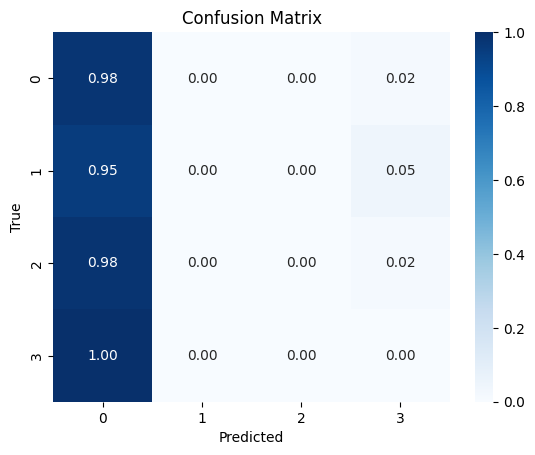

Validation Accuracy of VorgabeRNN with dropout 0.2, learning rate 0.0005, hidden size 256: 0.5739

All tests completed.
Best Model: VorgabeGRU, Dropout: 0.1, Learning Rate: 0.001, Hidden Size: 128, Accuracy: 0.6483


In [ ]:
test_space = {
    "model": [VorgabeLSTM, VorgabeGRU, VorgabeRNN],
    'lr': [0.001, 0.0005],
    'hidden_size': [128, 256],
    'dropout': [0.1, 0.2]
}

results = []
print("Starting tests with different configurations...")

train_set = ECGDataset(train_df, augmentation=None)
val_set = ECGDataset(val_df)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(42), num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

for model_cls in test_space["model"]:
  for dropout in test_space["dropout"]:
    for hidden_size in test_space["hidden_size"]:
      for lr in test_space["lr"]:
          print(f"Testing {model_cls.__name__} with dropout {dropout}, learning rate {lr}, hidden size {hidden_size}")
          model = model_cls(hidden_size=hidden_size,
                            num_layers=2,
                            num_classes=NUM_CLASSES,
                            n_fft=N_FFT,
                            hop_length=HOP_LENGTH,
                            dropout_rate=dropout)
          device = "cuda" if torch.cuda.is_available() else "cpu"
          model = model.to(device)
          trained = train_model(model, train_loader, epochs=EPOCHS, lr=lr)
          acc = evaluate_model(trained, val_loader, device)

          print(f"Validation Accuracy of {model_cls.__name__} with dropout {dropout}, learning rate {lr}, hidden size {hidden_size}: {acc:.4f}\n")
          results.append({"model": model_cls.__name__, "dropout": dropout, "learning_rate": lr, "hidden_size": hidden_size, "accuracy": acc})
          del trained
          torch.cuda.empty_cache()

del train_set, val_set, train_loader, val_loader

print("All tests completed.")
best = max(results, key=lambda x: x["accuracy"])
print(f"Best Model: {best['model']}, Dropout: {best['dropout']}, Learning Rate: {best['learning_rate']}, Hidden Size: {best['hidden_size']}, Accuracy: {best['accuracy']:.4f}")

Training RNN feature extractor...


Epoch 1/30: 100%|██████████| 83/83 [00:06<00:00, 12.76it/s]


Epoch 1: Train Loss: 1.0907, Train Acc: 57.37%


Epoch 2/30: 100%|██████████| 83/83 [00:04<00:00, 18.82it/s]


Epoch 2: Train Loss: 1.0780, Train Acc: 57.62%


Epoch 3/30: 100%|██████████| 83/83 [00:05<00:00, 16.32it/s]


Epoch 3: Train Loss: 1.0794, Train Acc: 57.90%


Epoch 4/30: 100%|██████████| 83/83 [00:04<00:00, 18.67it/s]


Epoch 4: Train Loss: 1.0635, Train Acc: 57.94%


Epoch 5/30: 100%|██████████| 83/83 [00:04<00:00, 18.64it/s]


Epoch 5: Train Loss: 1.0584, Train Acc: 57.67%


Epoch 6/30: 100%|██████████| 83/83 [00:05<00:00, 16.59it/s]


Epoch 6: Train Loss: 1.0578, Train Acc: 58.24%


Epoch 7/30: 100%|██████████| 83/83 [00:04<00:00, 18.87it/s]


Epoch 7: Train Loss: 1.0459, Train Acc: 57.69%


Epoch 8/30: 100%|██████████| 83/83 [00:04<00:00, 18.11it/s]


Epoch 8: Train Loss: 0.9899, Train Acc: 59.75%


Epoch 9/30: 100%|██████████| 83/83 [00:04<00:00, 16.88it/s]


Epoch 9: Train Loss: 0.8888, Train Acc: 64.19%


Epoch 10/30: 100%|██████████| 83/83 [00:04<00:00, 18.97it/s]


Epoch 10: Train Loss: 0.8547, Train Acc: 66.03%


Epoch 11/30: 100%|██████████| 83/83 [00:04<00:00, 17.96it/s]


Epoch 11: Train Loss: 0.8148, Train Acc: 67.29%


Epoch 12/30: 100%|██████████| 83/83 [00:04<00:00, 17.15it/s]


Epoch 12: Train Loss: 0.7602, Train Acc: 69.35%


Epoch 13/30: 100%|██████████| 83/83 [00:04<00:00, 18.70it/s]


Epoch 13: Train Loss: 0.7249, Train Acc: 71.86%


Epoch 14/30: 100%|██████████| 83/83 [00:04<00:00, 17.66it/s]


Epoch 14: Train Loss: 0.6902, Train Acc: 71.97%


Epoch 15/30: 100%|██████████| 83/83 [00:04<00:00, 17.95it/s]


Epoch 15: Train Loss: 0.6701, Train Acc: 73.63%


Epoch 16/30: 100%|██████████| 83/83 [00:04<00:00, 18.61it/s]


Epoch 16: Train Loss: 0.6072, Train Acc: 75.67%


Epoch 17/30: 100%|██████████| 83/83 [00:04<00:00, 17.00it/s]


Epoch 17: Train Loss: 0.5662, Train Acc: 77.67%


Epoch 18/30: 100%|██████████| 83/83 [00:04<00:00, 18.46it/s]


Epoch 18: Train Loss: 0.5084, Train Acc: 79.99%


Epoch 19/30: 100%|██████████| 83/83 [00:04<00:00, 18.64it/s]


Epoch 19: Train Loss: 0.4468, Train Acc: 82.56%


Epoch 20/30: 100%|██████████| 83/83 [00:05<00:00, 16.49it/s]


Epoch 20: Train Loss: 0.4517, Train Acc: 82.96%


Epoch 21/30: 100%|██████████| 83/83 [00:04<00:00, 18.52it/s]


Epoch 21: Train Loss: 0.3997, Train Acc: 86.20%


Epoch 22/30: 100%|██████████| 83/83 [00:04<00:00, 18.72it/s]


Epoch 22: Train Loss: 0.4122, Train Acc: 85.74%


Epoch 23/30: 100%|██████████| 83/83 [00:05<00:00, 16.59it/s]


Epoch 23: Train Loss: 0.3160, Train Acc: 88.18%


Epoch 24/30: 100%|██████████| 83/83 [00:04<00:00, 18.91it/s]


Epoch 24: Train Loss: 0.3111, Train Acc: 88.21%


Epoch 25/30: 100%|██████████| 83/83 [00:04<00:00, 18.74it/s]


Epoch 25: Train Loss: 0.2599, Train Acc: 91.03%


Epoch 26/30: 100%|██████████| 83/83 [00:05<00:00, 16.43it/s]


Epoch 26: Train Loss: 0.2364, Train Acc: 91.49%


Epoch 27/30: 100%|██████████| 83/83 [00:04<00:00, 19.16it/s]


Epoch 27: Train Loss: 0.2065, Train Acc: 93.01%


Epoch 28/30: 100%|██████████| 83/83 [00:04<00:00, 17.89it/s]


Epoch 28: Train Loss: 0.2140, Train Acc: 92.65%


Epoch 29/30: 100%|██████████| 83/83 [00:04<00:00, 17.27it/s]


Epoch 29: Train Loss: 0.1736, Train Acc: 93.79%


Epoch 30/30: 100%|██████████| 83/83 [00:04<00:00, 18.50it/s]


Epoch 30: Train Loss: 0.1974, Train Acc: 93.64%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 35.33it/s]


Final Validation Accuracy: 0.6537
              precision    recall  f1-score   support

           0       0.74      0.84      0.78       544
           1       0.27      0.21      0.24        84
           2       0.60      0.50      0.54       264
           3       0.07      0.06      0.06        35

    accuracy                           0.65       927
   macro avg       0.42      0.40      0.41       927
weighted avg       0.63      0.65      0.64       927



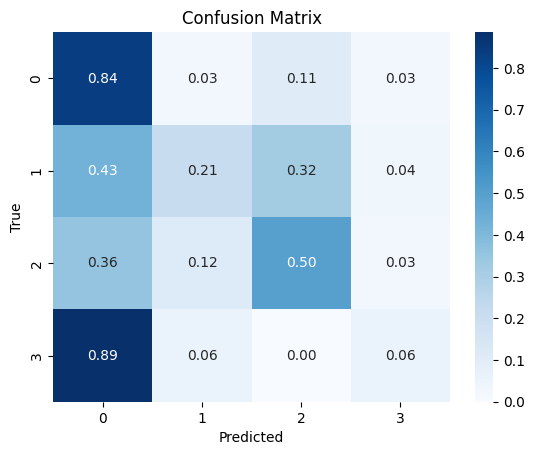

Validation Accuracy of: 0.6537



In [ ]:
train_set = ECGDataset(train_df, augmentation=None)
val_set = ECGDataset(val_df)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(42), num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

model = VorgabeGRU(hidden_size=128,
                  num_layers=2,
                  num_classes=NUM_CLASSES,
                  n_fft=N_FFT,
                  hop_length=HOP_LENGTH,
                  dropout_rate=0.1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
trained = train_model(model, train_loader, epochs=30, lr=0.001)
acc = evaluate_model(trained, val_loader, device)

print(f"Validation Accuracy of: {acc:.4f}\n")